/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Barra Barra 1: Voltaje = 1.0000 p.u., Ángulo = 0.00 grados
Barra Barra 2: Voltaje = 1.0334 p.u., Ángulo = -14.28 grados
Barra Barra 1A: Voltaje = 1.0315 p.u., Ángulo = -14.49 grados
Barra Barra 2A: Voltaje = 1.0292 p.u., Ángulo = -14.73 grados
Barra Barra 3A: Voltaje = 1.0284 p.u., Ángulo = -14.86 grados
Barra Barra 2B: Voltaje = 1.0274 p.u., Ángulo = -14.87 grados
Barra Barra 1B: Voltaje = 1.0324 p.u., Ángulo = -14.47 grados

Número de iteraciones: 1
Tolerancia utilizada: 1.00e-08 MVA


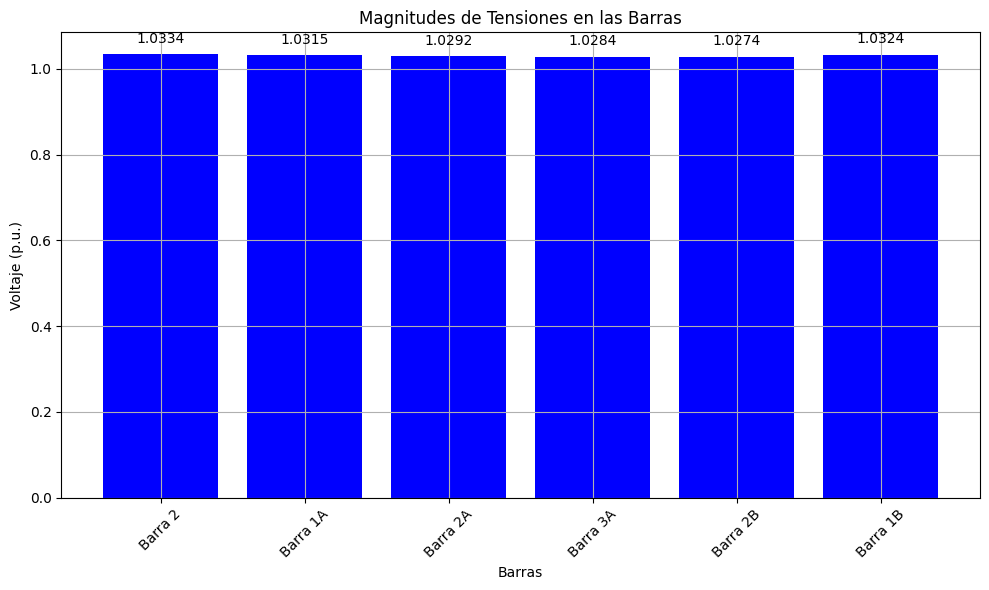

In [7]:
#SIMULACIÓN PARA FLUJO DE POTENCIA POR POWER PANDA

import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import math

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de gen [kV]
Vg_LL2 = 220 # Voltaje de barras
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q)
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q)
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q)
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q)
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q)

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Se añade fuente de generación conectada en la barra 1, (1[pu], el voltaje nominal [kV] se define en la barra a la que está conectada)
pp.create_ext_grid(net, bus=bus1, vm_pu=1, va_degree=0.0)

# Contador de iteraciones
iteraciones = 0

# Ejecutar el flujo de carga
success = False
while not success:
    iteraciones += 1
    pp.runpp(net, tolerance_mva=1e-8, max_iteration=1000)  # No es necesario ajustar max_iteration
    
    # Verificar si el flujo de carga convergió
    if net.converged:
        success = True

# Obtener resultados de las tensiones y ángulos en las barras
voltajes = net.res_bus.vm_pu.values  # Voltajes en p.u.
angulos = net.res_bus.va_degree.values  # Ángulos en grados

# Imprimir los resultados
for i in range(len(net.bus)):
    nombre = net.bus.name[i]
    voltaje = voltajes[i]
    angulo = angulos[i]
    print(f'Barra {nombre}: Voltaje = {voltaje:.4f} p.u., Ángulo = {angulo:.2f} grados')

print(f'\nNúmero de iteraciones: {iteraciones}')
print(f'Tolerancia utilizada: {1e-8:.2e} MVA')  # Mostramos la tolerancia utilizada, que es la especificada
# Obtener nombres de las barras (excluyendo la barra slack)
nombres_barras = net.bus.name[1:]

# Graficar las magnitudes de las tensiones con etiquetas numéricas
plt.figure(figsize=(10, 6))
bars = plt.bar(nombres_barras, voltajes[1:], color='blue')

plt.title('Magnitudes de Tensiones en las Barras')
plt.xlabel('Barras')
plt.ylabel('Voltaje (p.u.)')
plt.xticks(rotation=45)
plt.grid(True)

# Agregar etiquetas con los valores numéricos
for bar, voltage in zip(bars, voltajes[1:]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{voltage:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


/Users/josegutierrez/Library/Python/3.9/lib/python/site-packages/pandapower/create.py:2369: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  net.trafo.tap_phase_shifter.fillna(False, inplace=True)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Matriz Ybus (7x7):
                       0                           1  \
0  18.069305-833.143703j    -18.041806+  833.131714j   
1 -18.041806+833.131714j  28090.834926-45050.010168j   
2   0.000000+  0.000000j -14036.382810+22117.936550j   
3   0.000000+  0.000000j      0.000000+    0.000000j   
4   0.000000+  0.000000j      0.000000+    0.000000j   
5   0.000000+  0.000000j      0.000000+    0.000000j   
6   0.000000+  0.000000j -14036.382810+22117.936550j   

                            2                           3  \
0      0.000000+    0.000000j      0.000000+    0.000000j   
1 -14036.382810+22117.936550j      0.000000+    0.000000j   
2  23393.971351-36839.469289j  -9357.588540+14745.291033j   
3  -9357.588540+14745.291033j  16375.779946-25770.997696j   
4      0.000000+    0.000000j  -7018.191405+11058.968275j   
5      0.000000+    0.000000j      0.000000+    0.000000j   
6      0.000000+    0.000000j      0.000000+    0.000000j   

                            4              

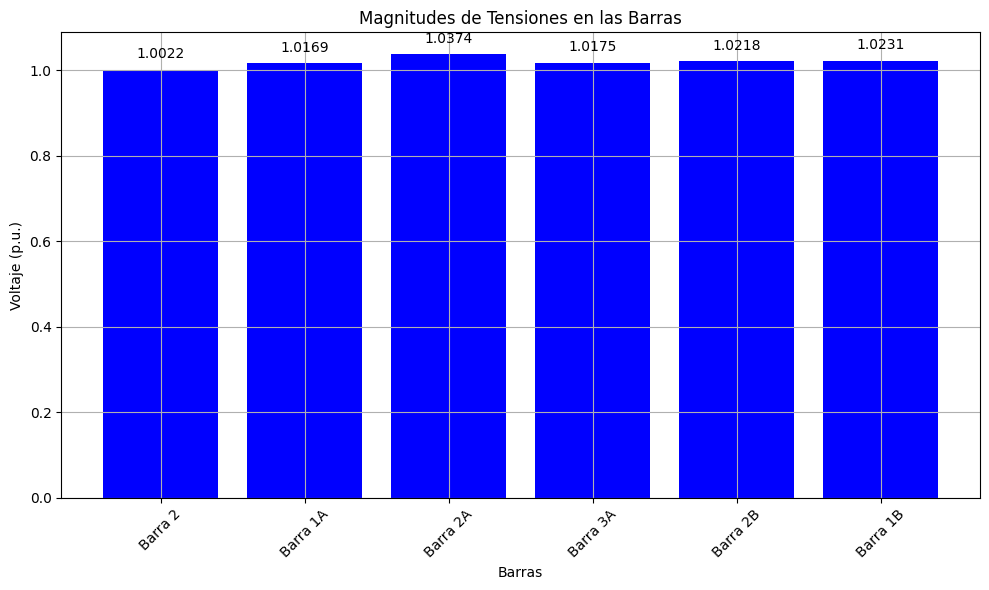

In [8]:
#SIMULACIÓN DE FLUJO DE POTENCIA POR NEWTON RAPHSON

import numpy as np
import matplotlib.pyplot as plt
import pandapower as pp
import pandas as pd

# Definimos los parámetros
f = 50  # frecuencia del sistema en [Hz]

Vg_LL = 110  # voltaje de gen [kV]
Vg_LL2 = 220 # Voltaje de barras
Imax = 0.457  # corriente máxima en las líneas [kA]

# Respecto a la carga
P = 150  # potencia activa en [MW]
Q = 100  # potencia reactiva en [Mvar]

# Crear red eléctrica
net = pp.create_empty_network()

# Añadir barras
bus1 = pp.create_bus(net, vn_kv=Vg_LL, name="Barra 1", slack=True)  # Barra 1 es designada como slack
bus2 = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2")  # Barra 2 se conecta la carga
bus1A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1A")  # Barra 1A se conecta la carga
bus2A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2A")  # Barra 2A se conecta la carga
bus3A = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 3A")  # Barra 3A se conecta la carga
bus2B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 2B")  # Barra 2B se conecta la carga
bus1B = pp.create_bus(net, vn_kv=Vg_LL2, name="Barra 1B")  # Barra 1B se conecta la carga

# Añadir líneas
pp.create_line(net, from_bus=bus2, to_bus=bus1A, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1A, to_bus=bus2A, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2A, to_bus=bus3A, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus3A, to_bus=bus2B, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus2B, to_bus=bus1B, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)
pp.create_line(net, from_bus=bus1B, to_bus=bus2, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", in_service=True)

# Añadir carga
pp.create_load(net, bus=bus1A, p_mw=0.2*P, q_mvar=0.2*Q, name="Carga 1A")
pp.create_load(net, bus=bus2A, p_mw=0.35*P, q_mvar=0.35*Q, name="Carga 2A")
pp.create_load(net, bus=bus3A, p_mw=0.15*P, q_mvar=0.15*Q, name="Carga 3A")
pp.create_load(net, bus=bus2B, p_mw=0.6*P, q_mvar=0.6*Q, name="Carga 1B")
pp.create_load(net, bus=bus1B, p_mw=0.1*P, q_mvar=0.1*Q, name="Carga 1B")

# Se añade transformador de 100 MVA 220/110 kV entre la barra 1 y la barra 2
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, name="trafo1", std_type="100 MVA 220/110 kV")

# Crear el generador en bus1 y definirlo como la barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0, va_degree=0, name="Barra Slack")

pp.runpp(net)
Ybus = net._ppc['internal']['Ybus']

# Convertir Ybus a un DataFrame de pandas para una mejor visualización
Ybus_df = pd.DataFrame(data=Ybus.todense())
print("Matriz Ybus (7x7):")
print(Ybus_df)

# Célula 3: Definición de la función de Newton-Raphson
def F(x):
    V = x[:len(x)//2]
    theta = x[len(x)//2:]
    
    P = np.zeros(len(V))
    Q = np.zeros(len(V))
    
    for i in range(len(V)):
        for j in range(len(V)):
            G = Ybus[i, j].real
            B = Ybus[i, j].imag
            P[i] += V[i] * V[j] * (G * np.cos(theta[i] - theta[j]) + B * np.sin(theta[i] - theta[j]))
            Q[i] += V[i] * V[j] * (G * np.sin(theta[i] - theta[j]) - B * np.cos(theta[i] - theta[j]))
    
    P_spec = net.res_bus.p_mw.values / net.sn_mva
    Q_spec = net.res_bus.q_mvar.values / net.sn_mva

    # Excluir barra slack de las ecuaciones
    P[0] = 0
    Q[0] = 0
    P_spec[0] = 0
    Q_spec[0] = 0
    
    return np.concatenate([P - P_spec, Q - Q_spec])

# Célula 4: Derivación del Jacobiano
def J(x):
    V = x[:len(x)//2]
    theta = x[len(x)//2:]
    
    J11 = np.zeros((len(V), len(V)))
    J12 = np.zeros((len(V), len(V)))
    J21 = np.zeros((len(V), len(V)))
    J22 = np.zeros((len(V), len(V)))
    
    for i in range(len(V)):
        for j in range(len(V)):
            G = Ybus[i, j].real
            B = Ybus[i, j].imag
            
            if i == j:
                for k in range(len(V)):
                    if k != i:
                        J11[i, j] += V[i] * V[k] * (-G * np.sin(theta[i] - theta[k]) + B * np.cos(theta[i] - theta[k]))
                        J12[i, j] += V[k] * (G * np.cos(theta[i] - theta[k]) + B * np.sin(theta[i] - theta[k]))
                        J21[i, j] += V[i] * V[k] * (G * np.cos(theta[i] - theta[k]) + B * np.sin(theta[i] - theta[k]))
                        J22[i, j] += V[k] * (G * np.sin(theta[i] - theta[k]) - B * np.cos(theta[i] - theta[k]))
                J11[i, j] += V[i] * Ybus[i, i].imag
                J12[i, j] += V[i] * Ybus[i, i].real
                J21[i, j] += V[i] * (-Ybus[i, i].real)
                J22[i, j] += V[i] * Ybus[i, i].imag
            else:
                J11[i, j] = V[i] * V[j] * (G * np.sin(theta[i] - theta[j]) - B * np.cos(theta[i] - theta[j]))
                J12[i, j] = V[i] * (G * np.cos(theta[i] - theta[j]) + B * np.sin(theta[i] - theta[j]))
                J21[i, j] = V[i] * V[j] * (-G * np.cos(theta[i] - theta[j]) - B * np.sin(theta[i] - theta[j]))
                J22[i, j] = V[i] * (G * np.sin(theta[i] - theta[j]) - B * np.cos(theta[i] - theta[j]))
    
    return np.block([[J11, J12], [J21, J22]])

# Célula 5: Implementación del método de Newton-Raphson
def newton_raphson(F, J, x0, tol=1e-6, max_iter=100):
    x = x0
    for i in range(max_iter):
        Jx = J(x)
        Fx = F(x)
        delta = np.linalg.solve(Jx, -Fx)
        x = x + delta
        if np.linalg.norm(delta, np.inf) < tol:
            print(f'Convergencia alcanzada en {i+1} iteraciones.')
            break
    else:
        print('No se alcanzó la convergencia.')
    return x


# Vector inicial (V y θ)
V0 = net.res_bus.vm_pu.values
theta0 = net.res_bus.va_degree.values * np.pi / 180
x0 = np.concatenate([V0, theta0])

# Resolver el sistema
sol = newton_raphson(F, J, x0)


# Mostrar resultados en el formato deseado
results = []
for i, bus_name in enumerate(net.bus.name):
    if i == 0:
        continue  # Saltar la barra slack
    V_pu = sol[i-1]  # Los índices en sol corresponden a V y theta, excluyendo la barra slack
    theta_deg = sol[i+len(net.bus)-1] * 180 / np.pi
    results.append(f"Barra {bus_name}: Voltaje = {V_pu:.4f} p.u., Ángulo = {theta_deg:.2f} grados")

# Imprimir resultados
for result in results:
    print(result)

# Resultados de las magnitudes de las tensiones y sus ángulos en las barras
bus_names = net.bus.name[1:]  # Excluir la barra slack de nuevo
V_pu = sol[:len(bus_names)]
theta_deg = sol[len(bus_names):] * 180 / np.pi


# Graficar las magnitudes de las tensiones
plt.figure(figsize=(10, 6))
bars = plt.bar(bus_names, V_pu, color='blue')

plt.title('Magnitudes de Tensiones en las Barras')
plt.xlabel('Barras')
plt.ylabel('Voltaje (p.u.)')
plt.xticks(rotation=45)
plt.grid(True)

# Agregar etiquetas con los valores numéricos
for bar, voltage in zip(bars, V_pu):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{voltage:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()




